# Portfolio optimiztion Bovespa stocks

This work implements a risk x return curve over a selected portfolio of Brazilian Stock Exchange BMF Bovespa.

Optimal portfolios are normally computed using the portfolio risk measured in terms of its variance. However, performance risk is a problem if the portfolio does not perform well. This project involves using linear programming techniques to define and handle the “Value- At-Risk” risk metric.

By evaluating historical prices to create future scenarios one can determine the “Value-At-Risk” of a specified portfolio. Using linear programming software to develop a returns model for the FTSE 100 one can, hence, calculate which stocks should be bought or sold in order to minimise the “Value-At-Risk” of a portfolio with an underlying required returns constraint. The developed tool will look at multi-period scenarios and seek to optimise the portfolio accordingly. 

This report documents the analysis of current ways of measuring single period “Value-At-Risk” and the formulation of a unique method of calculating multi-period “Value-At-Risk”. It goes on to describe an application which implements this model and highlights the results of exhaustive testing of the application. Ultimately, using back testing, this report demonstrates how the developed model would have, hypothetically, been able to make profits of up to 40% over the course of the past year while the FTSE 100 benchmark rose by only 27%.

## Data download

## Methods

Lets outline the theoretical aspects of the target. Basically we will use Brazilian Close Prices of Stock Market data from 1998 to 2005. 

### Efficient Frontier 

Markowitz's great insight was that the relevant information about securities can be summarized by three measures: the mean return (taken as the arithmetic mean), the standard deviation of the returns and the correlation with other assets' returns. The mean and the standard deviation can be used to plot the relative risk and return of any selection of securities.


Typically, the answer to the investment problem is not the selection of one asset above all others, but the construction of a portfolio of assets, i.e. diversification across a number of different securities. The key to diversification is the correlation across securities. Recall from data analysis and statistics that the correlation coefficient is a value between -1 and 1, and measures the degree of co-movement between two random variables, in this case stock returns.

The first efficient frontier was created by Harry Markowitz, using a handful of stocks from the New York Stock Exchange. Here it is, reproduced from his book Portfolio Selection Cowles Monograph 16, Yale University Press, 1959. It has a line going to the origin, because Markowitz was interested in the effects of combining risky assets with a riskless asset: cash.

This is state-of-the-art portfolio selection technology, however it is still based upon Markowitz's original optimization program. There are some basic features to remember:

    A minimum variance portfolio exists
    A maximum return portfolio is composed of a single asset.
    B,C,D & E are critical points at which one the set of assets used in the frontier changes, i.e. an asset drops out or comes in at these points.
    There are no assets to the northwest of the frontier. That is why we call it a frontier. It is the edge of the feasible combinations of risk and returns. 




### Sharp Ratio

The Modern Portfolio Theory says that to add an smartly picked asset to a portfolio can produce a decrease in the total portfolio risk without sacrifice return. Such diversification will serve to increase the Sharpe ratio of a portfolio.

The Sharpe ratio definition is

$sharp =  \frac{\bar{r_p} - r_f}{\rho_p}$

where $\bar{r_p}$ is the mean portfolio return, $r_f$ is the risk-free rate and $\rho_p$ is the standard deviation of portfolio returns.


In [3]:
library(quadprog)
library(quantmod)
library(ggplot2)

options(warn=-1)

In [4]:
# Here we need the folowing packages

tickers = c('VALE5.SA', 'PETR4.SA', 'ELET6.SA','CSAN3.SA', 'USIM5.SA', 'LAME4.SA')
# each new ticker add to list above demands a new execution of getSymbol function
getSymbols(tickers);

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.

Please see the Warning section of ‘?getSymbols.yahoo’ for details.

This message is shown once per session and may be disabled by setting
options("getSymbols.yahoo.warning"=FALSE).
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols


[1] "VALE5.SA" "PETR4.SA" "ELET6.SA" "CSAN3.SA" "USIM5.SA" "LAME4.SA"

In [6]:
# create an xts object, select only close prices and join
closePrices = do.call(cbind, lapply(tickers,  function(x) Cl(get(x))));
                                    
# interpolate all missing data in .xts objetc
closePrices = na.approx(closePrices)
                                    
# remove NA's. I dont know why na.rm="FALSE" didnt works here
closePrices = na.exclude(closePrices)
                                    
head(closePrices)

           VALE5.SA.Close PETR4.SA.Close ELET6.SA.Close CSAN3.SA.Close
2008-01-02          49.30         43.500        23.0208        18.5747
2008-01-03          50.00         42.800        22.7711        18.8858
2008-01-04          48.21         40.700        22.6213        18.8413
2008-01-07          47.51         39.505        23.0208        19.9967
2008-01-08          48.40         41.675        23.0707        20.9743
2008-01-09          48.50         42.460        23.9496        22.2185
           USIM5.SA.Close LAME4.SA.Close
2008-01-02        26.6000        7.73121
2008-01-03        26.9667        8.21217
2008-01-04        26.1667        7.83354
2008-01-07        24.9000        7.41398
2008-01-08        25.7833        7.21443
2008-01-09        26.5767        7.29118

In [7]:
# Compute daily returns over Close prices
#returns = apply(closePrices['2008//2015'], 2, function(x) diff(log(x)))
returns = do.call(cbind, lapply(seq(1,6),  function(x) monthlyReturn(closePrices[,x])))
names(returns) = tickers
head(returns)

              VALE5.SA    PETR4.SA    ELET6.SA    CSAN3.SA     USIM5.SA
2008-01-31 -0.09188639 -0.07586205 -0.03340896  0.31531063  0.033834586
2008-02-29  0.11369223  0.01305963  0.11310597  0.05129043  0.187879927
2008-03-31  0.01865223 -0.09158991  0.01612936 -0.10034421  0.004080639
2008-04-30  0.05512894  0.14069475  0.02381202  0.15000022  0.237195221
2008-05-30  0.01436837  0.16113741  0.04650856 -0.14381295  0.078117246
2008-06-30 -0.12251655 -0.05693880 -0.03518173  0.08203302 -0.097142857
              LAME4.SA
2008-01-31 -0.11647853
2008-02-29  0.15355696
2008-03-31 -0.15259677
2008-04-30 -0.08812240
2008-05-30  0.09663841
2008-06-30 -0.19540256

In [124]:
# calculate mean return for all months
meanReturns = apply(returns, 2, mean, na.rm="FALSE")

# Calculate var over monthly returns for all months
varReturns = apply(returns, 2, var, use="na.or.complete")
head(varReturns)
head(meanReturns)

VALE5.SA    PETR4.SA    ELET6.SA    CSAN3.SA    USIM5.SA    LAME4.SA 
0.012774827 0.017241888 0.013703150 0.012264999 0.039748984 0.009662867

VALE5.SA     PETR4.SA     ELET6.SA     CSAN3.SA     USIM5.SA     LAME4.SA 
0.0023425596 0.0003652106 0.0067809330 0.0122626900 0.0078604182 0.0108119878

In [102]:
eff.frontier = function (returns, short="no", maxAllocation=NULL, riskPremiumUp=.5, riskIncrement=.005){
  # return argument should be a m x n matrix with one column per security
  # short argument is whether short-selling is allowed; default is no (short selling prohibited)
  # maxAllocation is the maximum % allowed for any one security (reduces concentration)
  # riskPremiumUp is the upper limit of the risk premium modeled (see for loop below)
  # riskIncrement is the increment (by) value used in the for loop
  
  covariance = cov(returns)
  print(covariance)
  n = ncol(covariance)
  
  # Create initial Amat and bvec assuming only equality constraint (short-selling is allowed, no allocation constraints)
  Amat = matrix (1, nrow=n)
  bvec = 1
  meq = 1
  
  # Then modify the Amat and bvec if short-selling is prohibited
  if(short=="no"){
    Amat = cbind(1, diag(n))
    bvec = c(bvec, rep(0, n))
  }
  
  # And modify Amat and bvec if a max allocation (concentration) is specified
  if( !is.null(maxAllocation) ){
    if(maxAllocation > 1 | maxAllocation <0){
      stop("maxAllocation must be greater than 0 and less than 1")
    }
    if(maxAllocation*n < 1){
      stop("Need to set maxAllocation higher; not enough assets to add to 1")
    }
    Amat = cbind(Amat, -diag(n))
    bvec = c(bvec, rep(-maxAllocation, n))
  }
  
  # Calculate the number of loops based on how high to vary the risk premium and by what increment
  loops = riskPremiumUp / riskIncrement + 1
  loop = 1
  
  # Initialize a matrix to contain allocation and statistics
  # This is not necessary, but speeds up processing and uses less memory
  eff = matrix(nrow=loops, ncol=n+3)
  
  # Now I need to give the matrix column names
  colnames(eff) = c(colnames(returns), "Std.Dev", "Exp.Return", "sharpe")
  
  # Loop through the quadratic program solver
  for (i in seq(from=0, to=riskPremiumUp, by=riskIncrement)){
    dvec = colMeans(returns) * i # This moves the solution up along the efficient frontier
    sol = solve.QP(covariance, dvec=dvec, Amat=Amat, bvec=bvec, meq=meq)
    eff[loop,"Std.Dev"] = sqrt(sum(sol$solution *colSums((covariance * sol$solution)))) *100
    eff[loop,"Exp.Return"] = as.numeric(sol$solution %*% colMeans(returns)) * 100
    eff[loop,"sharpe"] = eff[loop,"Exp.Return"] / eff[loop,"Std.Dev"] * 100
    eff[loop,1:n] = sol$solution
    loop = loop+1
  }
  
  return(as.data.frame(eff))  
}

            VALE5.SA    PETR4.SA    ELET6.SA    CSAN3.SA    USIM5.SA
VALE5.SA 0.012774827 0.009272974 0.004423699 0.003508652 0.014592106
PETR4.SA 0.009272974 0.017241888 0.007024241 0.004816645 0.018246284
ELET6.SA 0.004423699 0.007024241 0.013703150 0.003681153 0.008066251
CSAN3.SA 0.003508652 0.004816645 0.003681153 0.012264999 0.007041064
USIM5.SA 0.014592106 0.018246284 0.008066251 0.007041064 0.039748984
LAME4.SA 0.002685004 0.003741155 0.003259846 0.005186674 0.006196971
            LAME4.SA
VALE5.SA 0.002685004
PETR4.SA 0.003741155
ELET6.SA 0.003259846
CSAN3.SA 0.005186674
USIM5.SA 0.006196971
LAME4.SA 0.009662867


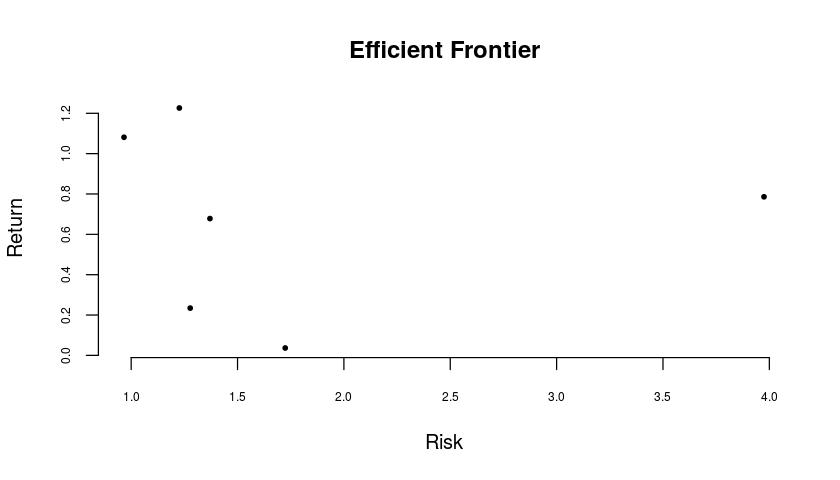

In [140]:
eff = eff.frontier(returns=returns, short="no", maxAllocation=0.5, riskPremiumUp=5.5, riskIncrement=.01);
effOptimalPoint = eff[eff$sharpe==max(eff$sharpe),];

options(repr.plot.width=7, repr.plot.height=4)

plot(varReturns*100, meanReturns*100, type="p", xlab="Risk", ylab="Return", 
     main="Efficient Frontier", 
     bty="n", cex=0.5, cex.axis=0.6, pch=19)


points(effOptimalPoint$Std.Dev, effOptimalPoint$Exp.Return,  col="red", pch=19)

risk = round(effOptimalPoint$Std.Dev, digits=2)
sharp = round(effOptimalPoint$sharpe, digits=2)
expReturn = round(effOptimalPoint$Exp.Return, digits=2)

text(geom="text", x=effOptimalPoint$Std.Dev, y=effOptimalPoint$Exp.Return,
           label=paste("Risk: ", risk ,"\nReturn: ", expReturn, "%\nSharpe: ", sharp, "%", sep=""), pos=1, offset=2)

            VALE5.SA    PETR4.SA    ELET6.SA    CSAN3.SA    USIM5.SA
VALE5.SA 0.012774827 0.009272974 0.004423699 0.003508652 0.014592106
PETR4.SA 0.009272974 0.017241888 0.007024241 0.004816645 0.018246284
ELET6.SA 0.004423699 0.007024241 0.013703150 0.003681153 0.008066251
CSAN3.SA 0.003508652 0.004816645 0.003681153 0.012264999 0.007041064
USIM5.SA 0.014592106 0.018246284 0.008066251 0.007041064 0.039748984
LAME4.SA 0.002685004 0.003741155 0.003259846 0.005186674 0.006196971
            LAME4.SA
VALE5.SA 0.002685004
PETR4.SA 0.003741155
ELET6.SA 0.003259846
CSAN3.SA 0.005186674
USIM5.SA 0.006196971
LAME4.SA 0.009662867


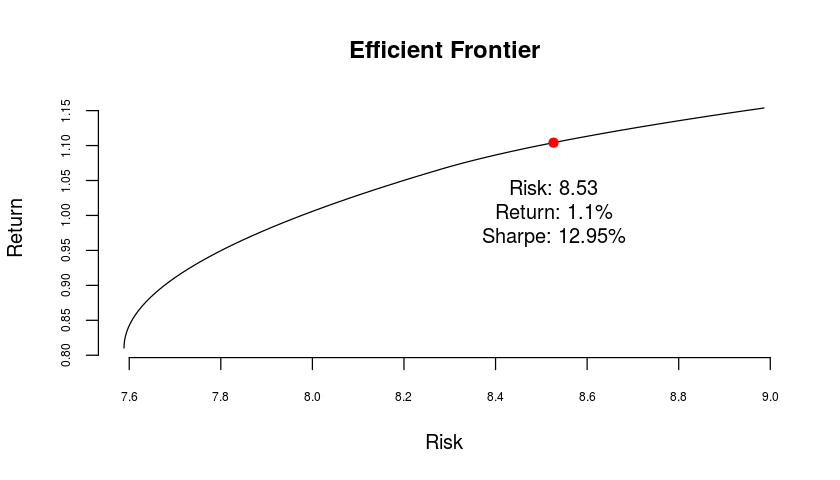

In [142]:
eff = eff.frontier(returns=returns, short="no", maxAllocation=0.5, riskPremiumUp=3, riskIncrement=.01);
effOptimalPoint = eff[eff$sharpe==max(eff$sharpe),];

options(repr.plot.width=7, repr.plot.height=4)


plot(eff$Std.Dev, eff$Exp.Return, type="l", xlab="Risk", ylab="Return", 
     main="Efficient Frontier", 
     bty="n", cex=0.5, cex.axis=0.6, pch=19)

points(varReturns*100, meanReturns*100, type="p", xlab="Risk", ylab="Return", 
     main="Efficient Frontier", 
     bty="n", cex=0.5, cex.axis=0.6, pch=19)

points(effOptimalPoint$Std.Dev, effOptimalPoint$Exp.Return,  col="red", pch=19)

risk = round(effOptimalPoint$Std.Dev, digits=2)
sharp = round(effOptimalPoint$sharpe, digits=2)
expReturn = round(effOptimalPoint$Exp.Return, digits=2)

text(geom="text", x=effOptimalPoint$Std.Dev, y=effOptimalPoint$Exp.Return,
           label=paste("Risk: ", risk ,"\nReturn: ", expReturn, "%\nSharpe: ", sharp, "%", sep=""), pos=1, offset=2)